# Clustering for gevtev

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/gevtev_TeVspectrum_normalized.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.055155,0.201477,0.000004,0.235066,0.028249,0.0,0.391619,0.072840,0.013193,0.002028,0.000367,b' ',b'bll ',b'',b'hbl',0
1,0.069119,0.073172,0.003407,0.038325,0.145615,0.0,0.134071,0.020429,0.006452,0.059379,0.450031,b' ',b'snr ',b'',b'snr',0
2,0.358190,0.178179,0.096737,0.268908,0.097987,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,0.269005,0.157462,0.139724,0.220561,0.213247,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,0.427725,0.147237,0.104148,0.231066,0.089825,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

* ### earth mover's distance

In [41]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)

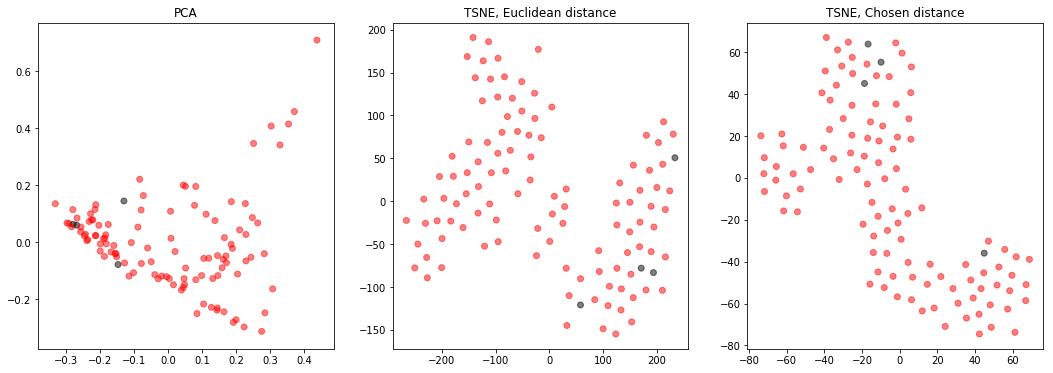

In [42]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=700)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=300)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [43]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.14346804856936712)

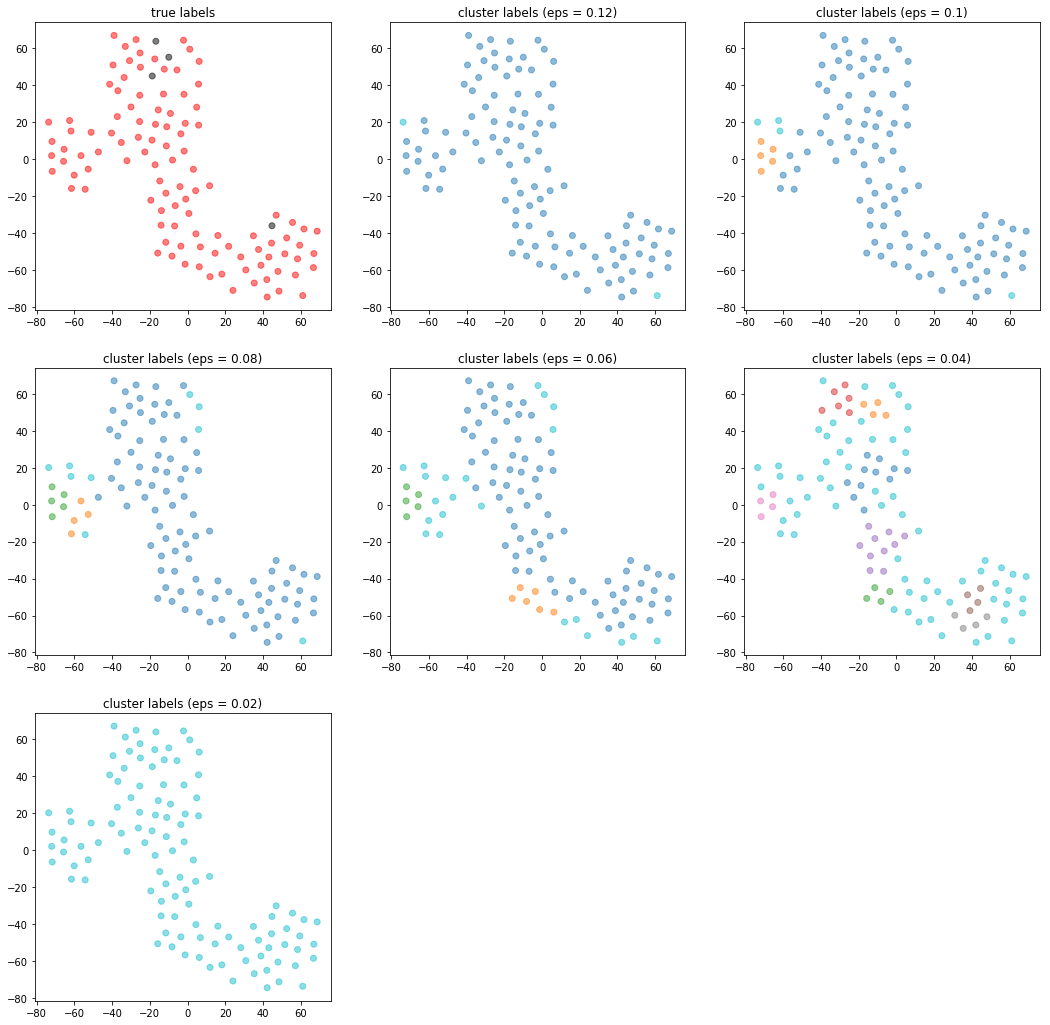

In [45]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=300)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.01 * i for i in range(12, 0, -2)]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [46]:
eps = 0.06

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0


1 cluster (tab:orange)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0
57,b' ',b'PSR ',b'',b'pwn',0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0


2 cluster (tab:green)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0
98,b'1FGL J2001.1+4351 ',b'bll ',b'',b'ibl',0
108,b'1FGL J2250.1+3825 ',b'bll ',b'',b'hbl',0


3 cluster (tab:red)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
16,b' ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


4 cluster (tab:purple)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
56,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',0


5 cluster (tab:brown)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
72,b'1FGL J1640.8-4634c',b'spp ',b'',b'pwn',0
91,b'1FGL J1834.3-0842c',b'snr ',b'',b'unid',0
92,b' ',b'PWN ',b'',b'unid',0


6 cluster (tab:pink)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
85,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
86,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


-1 cluster (tab:cyan)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b' ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
73,b' ',b'spp ',b'',b'unid',0
83,b' ',b' ',b'',b'unid',0
84,b'1FGL J1745.6-2900c',b'spp ',b'',b'unid',0


* ### euclidean distance

In [14]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

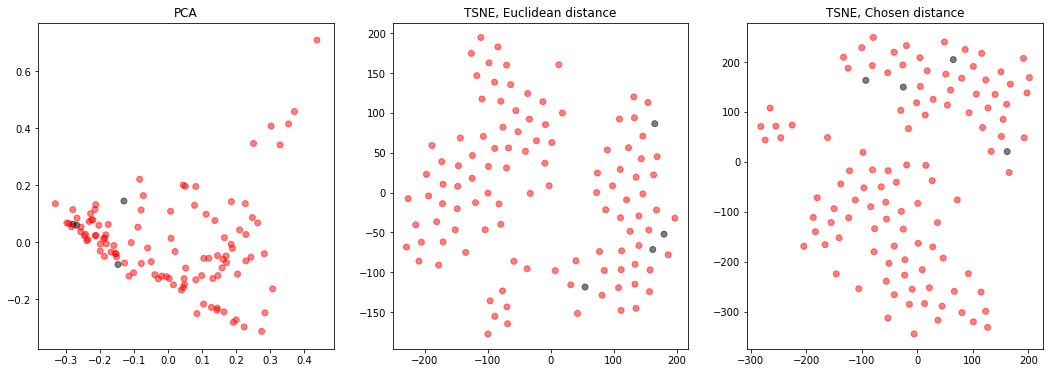

In [15]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=700, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=800)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [16]:
spectra_distances.min(), spectra_distances.max()

(0.0, 1.1313283975015185)

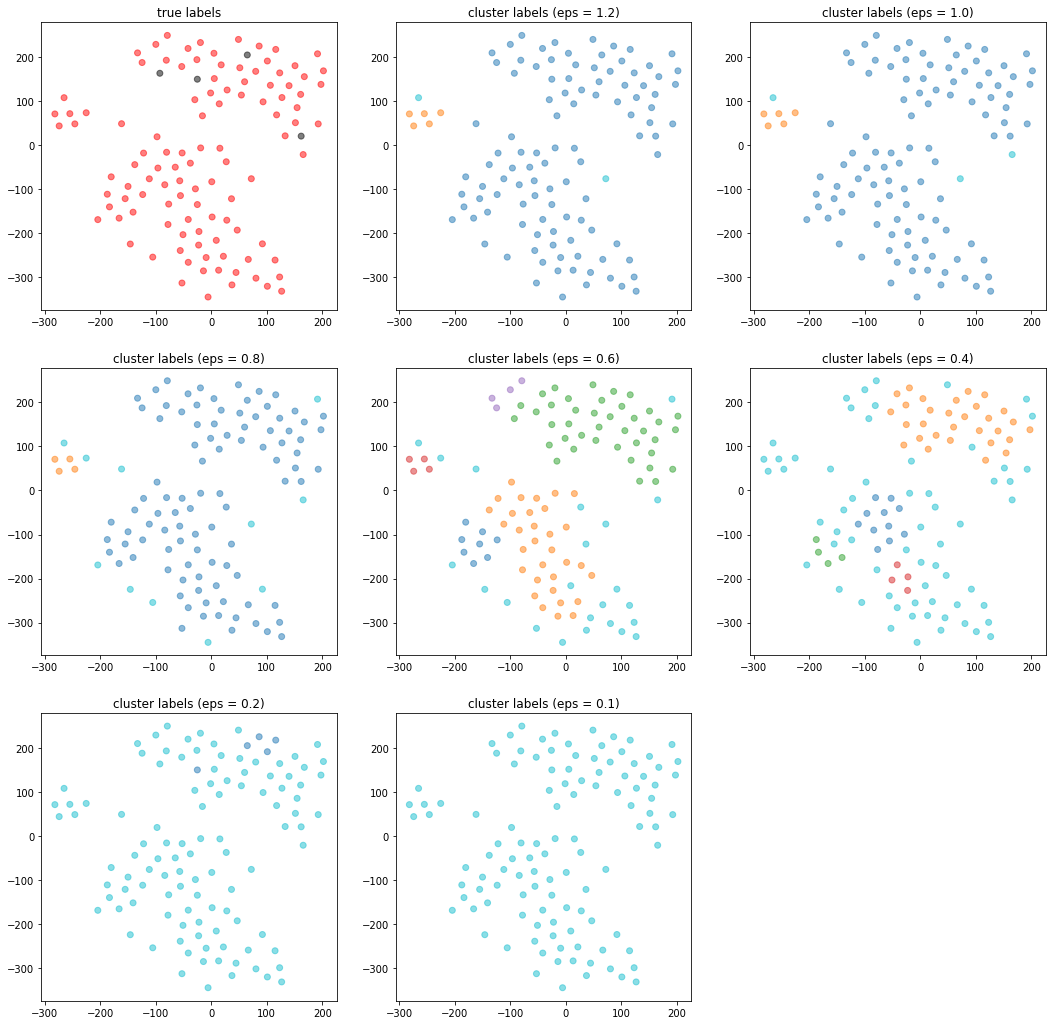

In [17]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=800)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.1 * i for i in range(12, 0, -2)] + [0.1]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [18]:
eps = 0.6

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0
107,b'1FGL J2244.0+2021 ',b'bll ',b'',b'ibl',0


1 cluster (tab:orange)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
24,b' ',b'PWN ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0


2 cluster (tab:green)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
33,b' ',b'PWN ',b'',b'pwn',0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0


3 cluster (tab:red)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b' ',b'bll ',b'',b'hbl',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0


4 cluster (tab:purple)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
16,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


5 cluster (tab:brown)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0


6 cluster (tab:pink)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0
75,b'1FGL J1711.7-3944c',b'SNR ',b'',b'snr',0


7 cluster (tab:gray)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
71,b'1FGL J1626.0-4917c',b' ',b'',b'unid',0
105,b'1FGL J2202.8+4216 ',b'BLL ',b'',b'lbl',0


8 cluster (tab:olive)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
78,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',0
83,b' ',b' ',b'',b'unid',0
85,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
86,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


-1 cluster (tab:cyan)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
1,b' ',b'snr ',b'',b'snr',0
13,b' ',b'rdg ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
37,b' ',b'bll ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0
56,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',0
57,b' ',b'PSR ',b'',b'pwn',0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0


* ### cosine distance

In [26]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

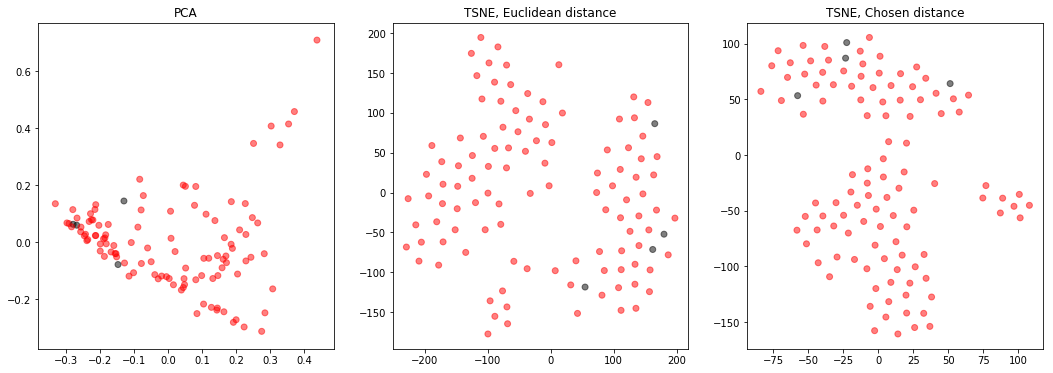

In [27]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=700, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=400)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [28]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.9996547859491316)

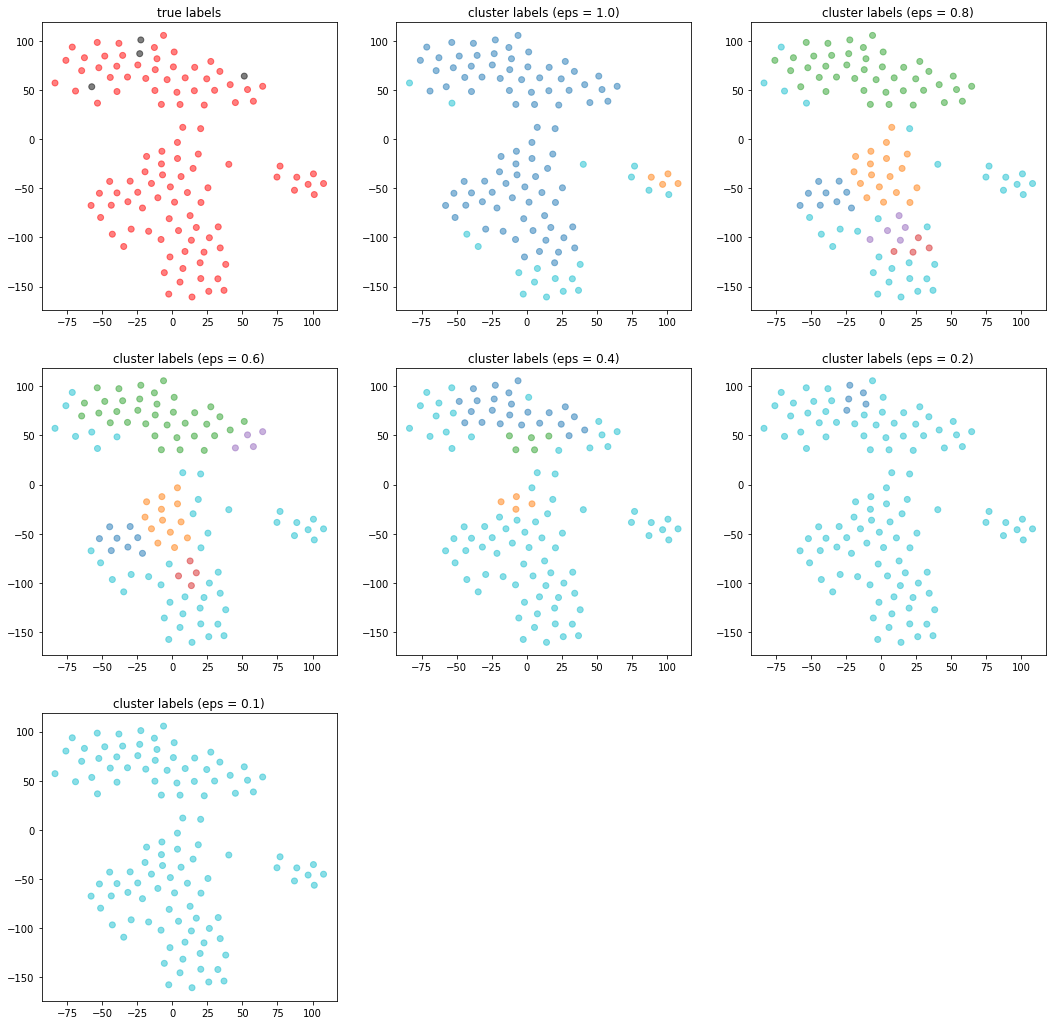

In [29]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=400)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.1 * i for i in range(10, 0, -2)] + [0.1]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [30]:
eps = 0.6

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0
107,b'1FGL J2244.0+2021 ',b'bll ',b'',b'ibl',0


1 cluster (tab:orange)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0
60,b'1FGL J1426.9+2347 ',b'BLL ',b'',b'hbl',0


2 cluster (tab:green)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
5,b' ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0


3 cluster (tab:red)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0


4 cluster (tab:purple)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
16,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0


5 cluster (tab:brown)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0


6 cluster (tab:pink)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
81,b'1FGL J1744.2+1934 ',b'bll ',b'',b'hbl',0
99,b'1FGL J2009.5-4849 ',b'BLL ',b'',b'hbl',0
110,b'1FGL J2347.1+5142 ',b'bll ',b'',b'hbl',0


7 cluster (tab:gray)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
78,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',0
83,b' ',b' ',b'',b'unid',0
85,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
86,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


-1 cluster (tab:cyan)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
1,b' ',b'snr ',b'',b'snr',0
10,b' ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
33,b' ',b'PWN ',b'',b'pwn',0
37,b' ',b'bll ',b'',b'hbl',0


* ### energy distance

In [31]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

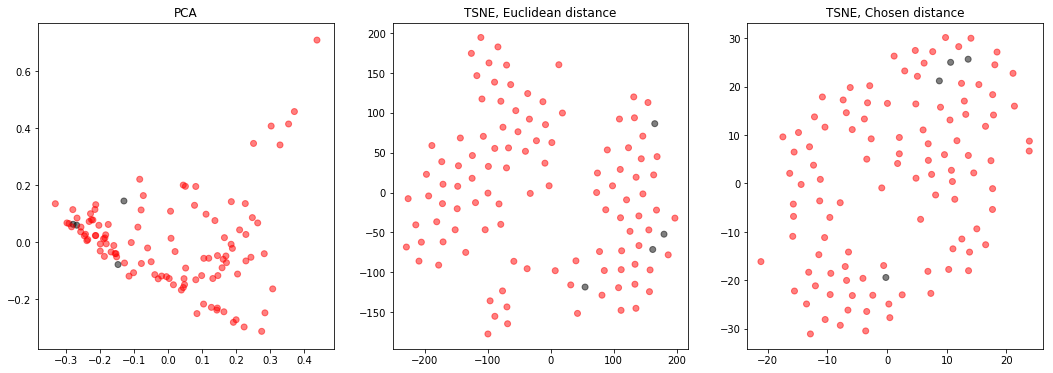

In [32]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=700, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=300)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [33]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.32025876286399274)

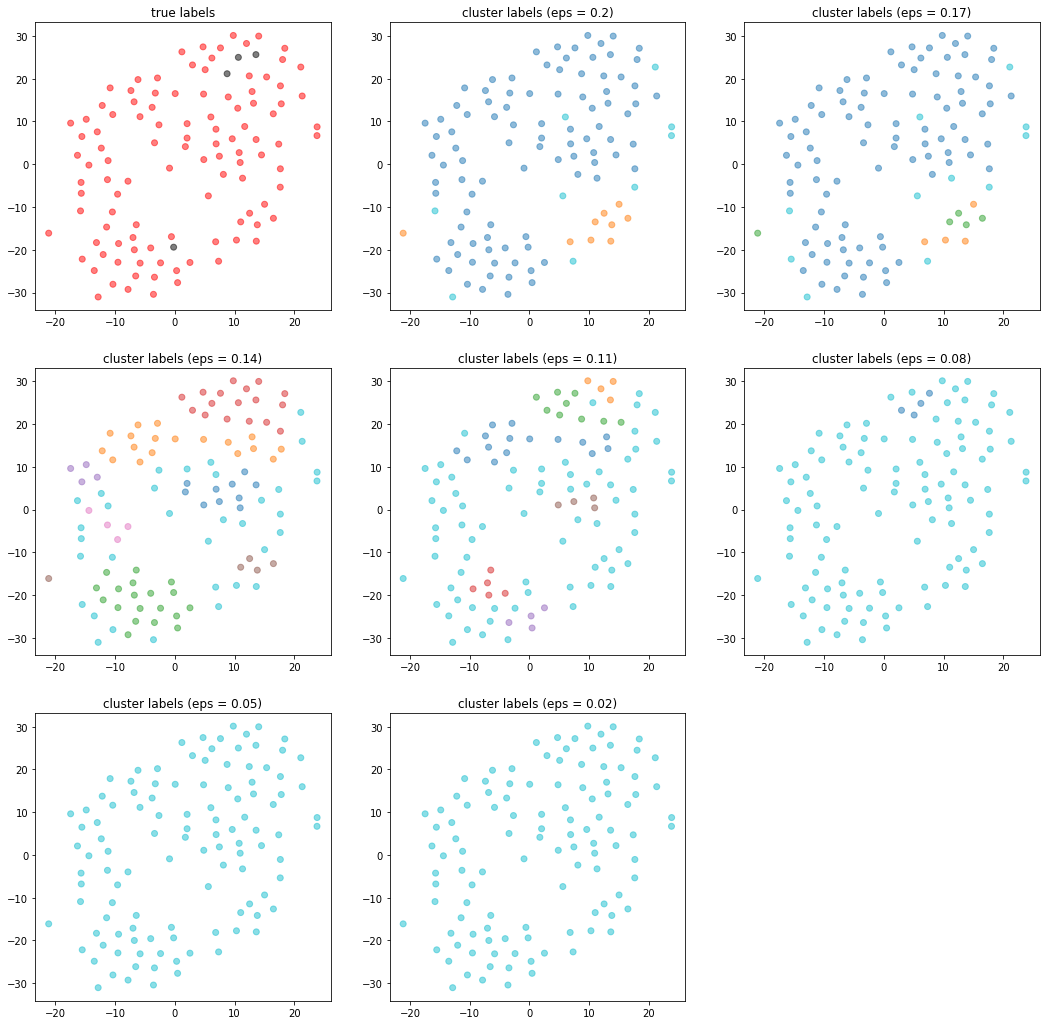

In [39]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=300)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.01 * i for i in range(20, 0, -3)]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [40]:
eps = 0.14

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
51,b'1FGL J1224.7+2121 ',b'FSRQ ',b'',b'fsrq',0
53,b'1FGL J1256.2-0547 ',b'FSRQ ',b'',b'fsrq',0
58,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0
59,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0
82,b' ',b'spp ',b'',"b'unid,snr,mc'",0
93,b'1FGL J1848.1-0145c',b' ',b'',b'unid',0
94,b' ',b' ',b'',b'unid',0


1 cluster (tab:orange)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
57,b' ',b'PSR ',b'',b'pwn',0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0


2 cluster (tab:green)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
22,b' ',b'PWN ',b'',b'psr',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0


3 cluster (tab:red)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
5,b' ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
33,b' ',b'PWN ',b'',b'pwn',0
37,b' ',b'bll ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0
55,b' ',b'bcu ',b'',b'hbl',0
60,b'1FGL J1426.9+2347 ',b'BLL ',b'',b'hbl',0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0
62,b'1FGL J1442.8+1158 ',b'bll ',b'',b'hbl',0


4 cluster (tab:purple)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
39,b' ',b'PSR ',b'',b'pwn',0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
44,b'1FGL J1119.4-6127c',b'PSR ',b'',b'pwn',0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0
64,b'1FGL J1459.4-6053 ',b'PSR ',b'',b'pwn',0


5 cluster (tab:brown)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
98,b'1FGL J2001.1+4351 ',b'bll ',b'',b'ibl',0


6 cluster (tab:pink)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
16,b' ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


7 cluster (tab:gray)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
99,b'1FGL J2009.5-4849 ',b'BLL ',b'',b'hbl',0
104,b'1FGL J2158.8-3013 ',b'bll ',b'',b'hbl',0
109,b'1FGL J2323.4+5849 ',b'snr ',b'',b'snr',0


8 cluster (tab:olive)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
56,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',0


9 cluster (tab:cyan)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0
108,b'1FGL J2250.1+3825 ',b'bll ',b'',b'hbl',0


IndexError: list index out of range